In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
'''Consider the discrete-time asset allocation example in section 8.4 of Rao and Jelvis. Suppose the single-time-step return of the risky asset from time t to t+1 as Yt = a, prob = p
and b, prob = (1-p). Suppose that T=10, use the TD method to find the Q function and hence the optimal strategy'''

'Consider the discrete-time asset allocation example in section 8.4 of Rao and Jelvis. Suppose the single-time-step return of the risky asset from time t to t+1 as Yt = a, prob = p\nand b, prob = (1-p). Suppose that T=10, use the TD method to find the Q function and hence the optimal strategy'

In [2]:
from __future__ import annotations
from abc import ABC, abstractmethod
from dataclasses import dataclass
from collections import defaultdict
from scipy.stats import binom
import numpy as np
from typing import Dict, Sequence
import itertools
import random
import operator
from operator import itemgetter
import time

'''
Initial Assumptions
- Discrete Time
- Discrete Returns: +/-1 (daily)
- 1 Stock - Follows Binomial Distribution payout
- Utility - CARA function for final step reward Constant Absolute Risk Aversion
- T = 10 based on Assignment specification
- No fractional investments (i.e. only units)
- Assuming W_0 initial wealth = 0
- Assume NO CONSUMPTION of wealth at any Time t<T - i.e. Reward = 0 for 0<=t<T and utility at T
- Unconstrained allocation amount
''' 

'''
Shorting has a small benefit here - this world assumes no borrowing cost and returns are binary (i.e. won't explode to infinity) which means when you short,
You actually earn interest on the cash you get by shorting.
'''

ITERATIONS=10
GAMMA=1
COEFFICIENT_OF_CARA=1
INVESTMENT_LIMIT_MAX=1
INVESTMENT_LIMIT_MIN=-1
SPLITS=2
RESOLUTION=1e-2
RISK_FREE_RATE=0.05
PROBABILITY_PRICE_UP=0.4 #Probability of risky asset increasing
PRICE_A=0.2
PRICE_B=-0.1
INITIAL_WEALTH=0
RISKY_RETURN_DISTRIBUTION={PRICE_A:PROBABILITY_PRICE_UP, PRICE_B:1-PROBABILITY_PRICE_UP}

'''State'''
@dataclass(frozen=True)
class WealthState:
    time: int #time state I am in
    wealth: int #for now it will be int
    termination_time:int = ITERATIONS
    
    def __eq__(self, other):
        return (self.time == other.time) and \
               (self.wealth == other.wealth)
    
    def isTerminal(self):
        return self.time == self.termination_time

'''ACTIONS'''
@dataclass(frozen=True)
class InvestmentAction:
    risky_investment_amount: float
    
    def __eq__(self, other):
        return self.risky_investment_amount == other.risky_investment_amount
    
    def action_to_next_state(self, ws: WealthState, risky_return) -> WealthState:
        next_expected_wealth = wealth_func(ws, self.risky_investment_amount, risky_return)
        new_state = WealthState(time=ws.time+1, 
                                wealth=next_expected_wealth,
                               )
        return new_state
    
    @staticmethod
    def get_all_actions(investment_limit_min: int = INVESTMENT_LIMIT_MAX,
                        invesment_limit_max: int = INVESTMENT_LIMIT_MIN,
                        splits: int = SPLITS
                       ) -> Sequence[InvestmentAction]:
        all_actions = list()
        allocations = np.linspace(investment_limit_min,invesment_limit_max,splits).tolist()
        for alloc in allocations:
            all_actions.append(InvestmentAction(risky_investment_amount=alloc))
        
        return all_actions
    
'''REWARD'''
'''CARA UTILITY'''
def cara_func(x :int, alpha=COEFFICIENT_OF_CARA) -> float:
    return - np.exp(-alpha * x)/alpha

def wealth_func(ws: WealthState, risky_asset_allocation, risky_asset_return: float,risk_free_return: float = RISK_FREE_RATE) -> float:
    # print(f'{risky_asset_allocation} * ({risky_asset_return} - {risk_free_return}) + {ws.wealth} * {(1 + risk_free_return)}')
    wealth = risky_asset_allocation * (risky_asset_return - risk_free_return) + ws.wealth * (1 + risk_free_return)
    return wealth

'''TRANSITIONS'''
'''Returns a sequence indexed by time. Essentially, its a sequence of possible states at a given time assuming all actions
are applied to each state - every action will result in 2 states (price up and price down)'''
def get_all_state_actions(iterations, available_actions, initial_state, risky_return_distribution=RISKY_RETURN_DISTRIBUTION) \
-> Sequence[Dict[WealthState, Dict[WealthState, float]]]:
    state_tree = defaultdict(dict)
    current_states = [initial_state]
    for i in range(iterations):
        next_states_list = []
        for state in current_states:
            for action , action_prob in available_actions.items():
                next_states_from_action = {action.action_to_next_state(state,risky_return): 
                               (risky_return_prob * action_prob)
                               for risky_return, risky_return_prob in risky_return_distribution.items()}
                state_tree[state][action]=next_states_from_action
                for next_state in [*next_states_from_action.keys()]:
                    next_states_list.append(next_state)

        current_states = next_states_list
        
    return state_tree

'''
MDP PROCESS
1. Decrement from time T back down to 0 to calculate the values for each state.
2. each time_step: T-1 = r + discount * E[G_T|S]
'''

time_start = time.time()
initial_state = ws = WealthState(time=0,wealth=INITIAL_WEALTH)
all_actions = InvestmentAction.get_all_actions()
initial_actions = {a: 1/len(all_actions) for a in all_actions}
all_state_actions = get_all_state_actions(ITERATIONS, initial_actions, ws)

#Define a state action reward mapping - for each time - state:{action:{next_state: expeted_reward <-- cause its probabilistic}}
#Applicable for finite states only.
def get_state_action_value_map(state_actions, reward_func=cara_func, gamma=GAMMA, iterations=ITERATIONS):
    
    def get_reward(state,action):
        next_states_probablity = state_actions[state][action]
        total_reward = 0
        for next_state, action_return_probability in next_states_probablity.items():
            if next_state.isTerminal():
                total_reward += cara_func(next_state.wealth) * action_return_probability
            else:
                next_state_actions = state_actions[next_state]
                for action, _ in next_state_actions.items():
                    total_reward += get_reward(next_state,action) * action_return_probability
                    
        return total_reward
            
    state_action_value_map = defaultdict(lambda: defaultdict(float))
    
    for i in reversed(range(iterations)):
        states_at_t = [state for state in state_actions.keys() if state.time == i]
        for (state_at_t) in states_at_t:
            next_state_actions = state_actions[state_at_t]
            discount = gamma ** (iterations - i)
            for action, next_states in next_state_actions.items():
                reward = get_reward(state_at_t,action)
                state_action_value_map[state_at_t][action] = discount * reward 
    
    return state_action_value_map

state_action_value_map = get_state_action_value_map(all_state_actions)

#Initialize a random policy - randomly choose an action to determine an initial policy
def policy_evaluation(policy):
    state_action_value_map = get_state_action_value_map(policy)
    q_function = defaultdict(float)
    for (state, actions) in policy.items():
        for action , _ in actions.items():
            action_next_state_values = state_action_value_map[state][action]
            q_function[(state,action)] = action_next_state_values
    
    return q_function

###Value Iteration - greedy policy - choose the action from value function that gives you the highest expected reward
def converged(q_function_1,q_function_2):
    return max(abs(q_function_1[s] - q_function_2[s]) for s in q_function_1) < 1e-3

q_function_0 = policy_evaluation(all_state_actions)
q_function = q_function_0
new_q_function = q_function_0
previous_policy=all_state_actions

#This is value iteraton but learning Q-function so that we can get the optimal policy easily
def value_iteration():
    while not converged(q_function,new_q_function):        
        greedy_policy = defaultdict(lambda: defaultdict(float))
        greedy_q_function=defaultdict(float)
        for time in (range(ITERATIONS)):
            states_in_t = states_at_t = [state for state in all_state_actions.keys() if state.time == time]
            for state in states_in_t:
                actions = [*all_state_actions[state].keys()]
                action_value = {action: q_function[(state,action)] for action in actions}
                max_action = max(actions_value, key=actions_value.get)
                greedy_q_function[(state,max_action)] = action_value[max_action]
                other_actions = [action for action in actions if action != max_action]
                action_map = defaultdict(float)
                for risky_return, probability in RISKY_RETURN_DISTRIBUTION.items():
                    action_map[max_action.action_to_next_state(state,risky_return)] = probability
                    for other_action in other_actions:
                        greedy_policy[state][other_action] = {other_action.action_to_next_state(state,risky_return):0}
                        greedy_q_function[(state,other_action)] = q_function[(state,other_action)]

            states_after_t = [state for state in all_state_actions.keys() if state.time > time]
            for state in states_after_t:
                greedy_policy[state] = previous_policy[state]

            q_function.update(new_q_function)
            new_q_function.update(greedy_q_function)

def retrieve_optimal_policy_from_q_function(q_function):
    state = [state for state in all_state_actions.keys() if state.time == 0][0]
    for time in (range(ITERATIONS)):
        action_values = {a: q_function[(state,a)] for a in all_actions}
        action = max(action_values, key=action_values.get)
        risky_return = np.random.choice([*RISKY_RETURN_DISTRIBUTION.keys()], 
                                     p=[*RISKY_RETURN_DISTRIBUTION.values()])
        next_state = action.action_to_next_state(state,risky_return)
        print(f'State: {state} , Action: {action}')
        state = next_state
            
retrieve_optimal_policy_from_q_function(new_q_function)

time_end = time.time()
print(f'Elapse Time: {time_end - time_start} seconds')

State: WealthState(time=0, wealth=0, termination_time=10) , Action: InvestmentAction(risky_investment_amount=-1.0)
State: WealthState(time=1, wealth=0.15000000000000002, termination_time=10) , Action: InvestmentAction(risky_investment_amount=-1.0)
State: WealthState(time=2, wealth=0.30750000000000005, termination_time=10) , Action: InvestmentAction(risky_investment_amount=-1.0)
State: WealthState(time=3, wealth=0.4728750000000001, termination_time=10) , Action: InvestmentAction(risky_investment_amount=-1.0)
State: WealthState(time=4, wealth=0.6465187500000001, termination_time=10) , Action: InvestmentAction(risky_investment_amount=-1.0)
State: WealthState(time=5, wealth=0.8288446875000002, termination_time=10) , Action: InvestmentAction(risky_investment_amount=-1.0)
State: WealthState(time=6, wealth=1.0202869218750004, termination_time=10) , Action: InvestmentAction(risky_investment_amount=-1.0)
State: WealthState(time=7, wealth=1.2213012679687503, termination_time=10) , Action: Invest

In [608]:

value_function_data = defaultdict(float)

def execute_monte_carlo():
    initial_state = [state for state in all_state_actions.keys() if state.time == 0][0] #only one for now
    state = initial_state
    total_reward = 0
    visited_states = [initial_state]
    for t in range(ITERATIONS):
        actions = [*all_state_actions[state].keys()]
        chosen_action = np.random.choice(actions)
        risky_return = np.random.choice([*RISKY_RETURN_DISTRIBUTION.keys()], 
                                     p=[*RISKY_RETURN_DISTRIBUTION.values()])
        next_state = chosen_action.action_to_next_state(state,risky_return)
        total_reward += cara_func(next_state.wealth)
        visited_states.append(next_state)
        state = next_state
    
    for v in visited_states:
        value_function_data[v] = value_function_data[v] + total_reward/len(visited_states)

for i in range(10000):
    execute_monte_carlo()

# print(value_function_data)
for t in range(ITERATIONS):
    actions_in_t = [(s,value) for s, value in value_function_data.items() if s.time==t]
    best_action = max(actions_in_t,key=itemgetter(1))[0]
    print(f'At Time: {t}, Do: {best_action}')

At Time: 0, Do: WealthState(time=0, wealth=0, termination_time=10)
At Time: 1, Do: WealthState(time=1, wealth=0.15000000000000002, termination_time=10)
At Time: 2, Do: WealthState(time=2, wealth=0.30750000000000005, termination_time=10)
At Time: 3, Do: WealthState(time=3, wealth=0.4728750000000001, termination_time=10)
At Time: 4, Do: WealthState(time=4, wealth=0.6465187500000001, termination_time=10)
At Time: 5, Do: WealthState(time=5, wealth=0.8288446875000002, termination_time=10)
At Time: 6, Do: WealthState(time=6, wealth=1.0202869218750004, termination_time=10)
At Time: 7, Do: WealthState(time=7, wealth=1.2213012679687503, termination_time=10)
At Time: 8, Do: WealthState(time=8, wealth=1.432366331367188, termination_time=10)
At Time: 9, Do: WealthState(time=9, wealth=0.8845670211386721, termination_time=10)


[0, 1, 2, 3, 4]
1.111923826274482
1.167520017588206
1.2258960184676166
1.2871908193909973
1.3515503603605472


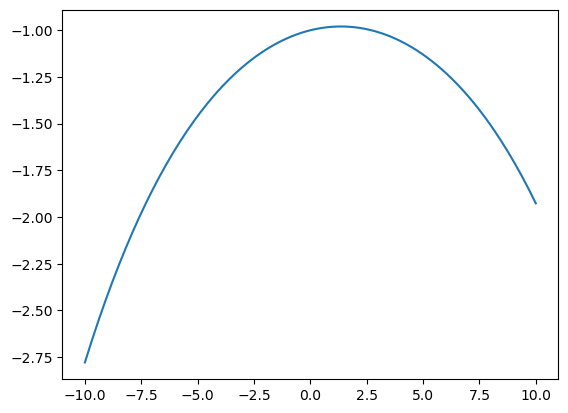

In [11]:
#optimal_step_analytical
import matplotlib.pyplot as plt

def analytical_solution(x, iterations=ITERATIONS):
    probability_part = np.log((PROBABILITY_PRICE_UP * (RISK_FREE_RATE - PRICE_A)) / ((PROBABILITY_PRICE_UP-1) * (RISK_FREE_RATE - PRICE_B)))
    time_part = COEFFICIENT_OF_CARA * ( (1 + RISK_FREE_RATE) ** (iterations - x - 1) ) * (PRICE_A - PRICE_B)
    optimal_step = (1/time_part) * probability_part
    return(optimal_step)
    
time_step = [ _ for _ in range(ITERATIONS) ]
print(time_step)
for time in time_step:
    step = time
    optimal_step = analytical_solution(step)
    print(optimal_step)

x = np.linspace(-10, 10, 200)
price_a_wealth = PROBABILITY_PRICE_UP * np.exp(-COEFFICIENT_OF_CARA * (x * (PRICE_A - RISK_FREE_RATE)))
price_b_wealth = (1-PROBABILITY_PRICE_UP) * np.exp(-COEFFICIENT_OF_CARA * (x * (PRICE_B - RISK_FREE_RATE)))
risk_free_wealth = np.exp(-COEFFICIENT_OF_CARA * INITIAL_WEALTH * (1 + RISK_FREE_RATE))
y = - (risk_free_wealth * (price_a_wealth + price_b_wealth))
# y = analytical_solution(x, iterations=20)
# print(f'minimim of y = {max(y)}')
# print([i if y[index] == max(y) else 0 for index, i in enumerate(x)])
# print(f'x coordinate for minimum = {}')
plt.plot(x,y)
plt.show()

### Test Functions

In [515]:
import unittest

def assert_lists_no_order(test_case, list1,list2):
    for i in list1:
        test_case.assertIn(i,list2)
        
    for i in list2:
        test_case.assertIn(i,list1)
        
# class TestWealthState(unittest.TestCase):
#     ws = WealthState(time=0,wealth=10,risky_asset_allocation=0)
    
#     def testWealthState(self):
#         self.assertEqual(self.ws.time,0)
#         self.assertEqual(self.ws.wealth,10)
#         self.assertEqual(self.ws.risky_asset_allocation,0)

class TestInvestmentAction(unittest.TestCase):
    ia = InvestmentAction(risky_investment_amount=2)
    ws = WealthState(time=0,wealth=10)
    
    def testNextState(self):
        ns = self.ia.action_to_next_state(self.ws,1)
        self.assertEqual(ns.time,1)
        self.assertEqual(ns.wealth,11)

    def testGetAllActions_Investment_Limit_1(self):
        ia = InvestmentAction(risky_investment_amount=1)
        actions = InvestmentAction.get_all_actions(1)
        expected_actions = [
            InvestmentAction(risky_investment_amount=1),
            InvestmentAction(risky_investment_amount=0),
            InvestmentAction(risky_investment_amount=-1)
        ]
        assert_lists_no_order(self,actions,expected_actions)
        
class TestCARAUtility(unittest.TestCase):
     def testCARA(self):
        # -( e ^ (- alpha * Wt) )/alpha
        self.assertEqual(cara_func(1, alpha=1),-1/np.e)
        self.assertEqual(cara_func(1, alpha=2), - ((np.e ** (-2 * 1))/2))

# class TestWealthFunction(unittest.TestCase):
#     def testWealthFunction_Price_0_0_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=0)
#         self.assertEqual(wealth_func(ws,0),10)
        
#     def testWealthFunction_Price_1_0_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=0)
#         self.assertEqual(wealth_func(ws,0),10)

#     def testWealthFunction_Price_0_1_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=1)
#         self.assertEqual(wealth_func(ws,1),10)
        
#     def testWealthFunction_Price_1_1_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=1)
#         self.assertEqual(wealth_func(ws,1),10)
        
#     def testWealthFunction_Price_2_1_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=1)
#         self.assertEqual(wealth_func(ws,2),11)
        
#     def testWealthFunction_Price_3_1_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=1)
#         self.assertEqual(wealth_func(ws,3),12)

#     def testWealthFunction_Price_3_2_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=2)
#         self.assertEqual(wealth_func(ws,3),14)
        
#     def testWealthFunction_Price_neg_3_2_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=10,risky_asset_allocation=2)
#         self.assertEqual(wealth_func(ws,-3),2)

#     def testWealthFunction_Zero_Initial_Price_neg_3_2_Risky_Asset(self):
#         ws = WealthState(time=0,wealth=0,risky_asset_allocation=2)
#         self.assertEqual(wealth_func(ws,-3),-6)

class TestRewardFunction(unittest.TestCase):
    def testRewardWhenStateIsNonTerminal(self):
        ws= WealthState(time=0,wealth=0,risky_asset_allocation=0)
        self.assertEqual(reward_function(ws),0)
    
    def testRewardWhenStateIsTerminal_at_1(self):
        ws= WealthState(time=1,wealth=0,risky_asset_allocation=1,termination_time=1)
        ## 0.5 * -e(-1 * -1)/1 + 0.5 * -e(-1 * 1)/1 = expected utility given the prices
        self.assertEqual(reward_function(ws,probability=0.5,alpha=1), (-np.e * 0.5) + (1/-np.e * 0.5))
        
    def testRewardWhenStateIsTerminal_at_2(self):
        ws= WealthState(time=2,wealth=0,risky_asset_allocation=1,termination_time=2)
        '''
        0.25 * -e(-1 * -2)
        0.5 * -e(-1 * 0)
        0.25 * -e(-1 * 2)
        '''
        expected_utility = round((0.25 * -np.e ** (-1 * -2)) + (0.5 * -np.e ** (-1 * 0)) + (0.25 * -np.e ** (-1 * 2)),5)
        self.assertEqual(round(reward_function(ws,probability=0.5,alpha=1),5), expected_utility)
        
    def testRewardWhenStateIsTerminal_at_1_Uneven_Chance(self):
        ws= WealthState(time=1,wealth=0,risky_asset_allocation=1,termination_time=1)
        ''' 0.6 * -e(-1 * -1)/1 + 0.4 * -e(-1 * 1)/1 = expected utility given the prices'''
        reward = round(reward_function(ws,probability=0.6,alpha=1),5)
        expected_reward = round((-np.e * 0.4) + (1/-np.e * 0.6),5)
        self.assertEqual(reward,expected_reward)
        
class TestGetAllStateActions(unittest.TestCase):
    def testGet_All_State_Actions_1_time_step(self):
        ws= WealthState(time=0,wealth=0,risky_asset_allocation=0,termination_time=1)
        actions = [InvestmentAction(risky_investment_amount=1),InvestmentAction(risky_investment_amount=0)]
        all_state_actions = get_all_state_actions(1,actions,ws)
        expected_state_actions = [{
            ws: {
                (InvestmentAction(risky_investment_amount=1),WealthState(time=1,wealth=0)):0.5,
                (InvestmentAction(risky_investment_amount=0),WealthState(time=1,wealth=0)):0.5
            }
        }]
        self.assertEqual(expected_state_actions,all_state_actions)
        
    def testGet_All_State_Actions_2_time_step(self):
        ws= WealthState(time=0,wealth=0,risky_asset_allocation=0,termination_time=1)
        actions = [InvestmentAction(risky_investment_amount=1),InvestmentAction(risky_investment_amount=0)]
        all_state_actions = get_all_state_actions(2,actions,ws)
        expected_state_actions = [{
            ws: {
                (InvestmentAction(risky_investment_amount=1),WealthState(time=1,wealth=0)):0.5,
                (InvestmentAction(risky_investment_amount=0),WealthState(time=1,wealth=0)):0.5
            }
        },
            {
            WealthState(time=1,wealth=0): {
                (InvestmentAction(risky_investment_amount=1),WealthState(time=2,wealth=0)):0.5,
                (InvestmentAction(risky_investment_amount=0),WealthState(time=2,wealth=0)):0.5
            },
            WealthState(time=1,wealth=0): {
                (InvestmentAction(risky_investment_amount=1),WealthState(time=2,wealth=0)):0.5,
                (InvestmentAction(risky_investment_amount=0),WealthState(time=2,wealth=0)):0.5
            }
        },
        ]
        self.assertEqual(expected_state_actions,all_state_actions)

class TestGetStateActionValueMap(unittest.TestCase):
    def testGetStateActionValueMap_1_iteration(self):
        gamma = 1
        probability = 0.5
        state_actions = {
            WealthState(time=0,wealth=0,termination_time=1): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=1,wealth=1.01,termination_time=1):0.5
                    WealthState(time=1,wealth=0.99,termination_time=1):0.5
                },   
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=1,wealth=0,termination_time=1):0.5
                    WealthState(time=1,wealth=0,termination_time=1):0.5
                }
            }
        }
        
        expected_state_action_value_map = defaultdict(float)
        expected_state_action_value_map.update({
            WealthState(time=0,wealth=0,termination_time=1): {
                InvestmentAction(risky_investment_amount=1):{
                    WealthState(time=1,wealth=1.01,termination_time=1): -np.e ** 1.01 * probability
                },   
                InvestmentAction(risky_investment_amount=0):{
                    WealthState(time=1,wealth=0,termination_time=1): -np.e ** 0 * (1-probability)
                }
            }
        })
        
        result = get_state_action_value_map(state_actions,reward_func=reward_function,gamma=1,iterations=1)
        print(result)
        self.assertEqual(expected_state_action_value_map,result)
        
unittest.main(argv=[''], verbosity=2, exit=False)

testCARA (__main__.TestCARAUtility) ... ok
testGet_All_State_Actions_1_time_step (__main__.TestGetAllStateActions) ... ERROR
testGet_All_State_Actions_2_time_step (__main__.TestGetAllStateActions) ... ERROR
testGetStateActionValueMap_1_iteration (__main__.TestGetStateActionValueMap) ... FAIL
testGetAllActions_Investment_Limit_1 (__main__.TestInvestmentAction) ... ok
testNextState (__main__.TestInvestmentAction) ... FAIL
testRewardWhenStateIsNonTerminal (__main__.TestRewardFunction) ... ERROR
testRewardWhenStateIsTerminal_at_1 (__main__.TestRewardFunction) ... ERROR
testRewardWhenStateIsTerminal_at_1_Uneven_Chance (__main__.TestRewardFunction) ... ERROR
testRewardWhenStateIsTerminal_at_2 (__main__.TestRewardFunction) ... 

defaultdict(<function get_state_action_value_map.<locals>.<lambda> at 0x7ff30bf4ee60>, {WealthState(time=1, wealth=1.01, termination_time=1): defaultdict(<class 'float'>, {InvestmentAction(risky_investment_amount=1): 0.0}), WealthState(time=0, wealth=0, termination_time=1): defaultdict(<class 'float'>, {InvestmentAction(risky_investment_amount=1): 0.0, InvestmentAction(risky_investment_amount=0): 0.0}), WealthState(time=1, wealth=0, termination_time=1): defaultdict(<class 'float'>, {InvestmentAction(risky_investment_amount=0): 0.0})})


ERROR

ERROR: testGet_All_State_Actions_1_time_step (__main__.TestGetAllStateActions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/jy/62vd459n2cjb81kdlvhf6vp00000gn/T/ipykernel_50524/1100119918.py", line 109, in testGet_All_State_Actions_1_time_step
    ws= WealthState(time=0,wealth=0,risky_asset_allocation=0,termination_time=1)
TypeError: __init__() got an unexpected keyword argument 'risky_asset_allocation'

ERROR: testGet_All_State_Actions_2_time_step (__main__.TestGetAllStateActions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/jy/62vd459n2cjb81kdlvhf6vp00000gn/T/ipykernel_50524/1100119918.py", line 121, in testGet_All_State_Actions_2_time_step
    ws= WealthState(time=0,wealth=0,risky_asset_allocation=0,termination_time=1)
TypeError: __init__() got an unexpected keyword argument 'risky_asset_allocation'

ERROR: testRewa